Importing libraries

In [12]:
import nltk
nltk.download("abc")
nltk.download('stopwords')
from nltk.corpus import abc
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
from collections import Counter
from torch.autograd import Variable
import random
random.seed(44)
import math
import numpy as np
punctuation = '!"#$%&\'()*+-/:;<=>?@[\\]^_`{|}~,.'
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

[nltk_data] Downloading package abc to /root/nltk_data...
[nltk_data]   Package abc is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Getting** dataset

In [0]:
words = abc.words()

In [0]:
threshold  = 0.000001
window_size = 3

*Supporting* functions

In [0]:
def preprocess(words):
    words = [i.lower() for i in words]
    words = [i for i in words if i not in punctuation]
    
    return words

def get_preprocess_and_sub_sampled_data(words):
    corpus = preprocess(words)
    counts = Counter(corpus)
    frequencies = {i:counts[i]/sum(list(counts.values())) for i in counts}
    metric = {i: (1-math.sqrt(threshold/frequencies[i])) for i in frequencies}
    subsampled_corpus = [i for i in corpus if random.random() <  1- metric[i]]

    return subsampled_corpus

def create_lookup_tables(words):
    vocab = Counter(words)
    n = list(vocab.items())
    n.sort(key = lambda x : x[1],reverse = True)
    word_to_int = {}
    for i in range(len(vocab)):
        word_to_int[n[i-1][0]] = i
        
    int_to_word = {}
    for i,k in word_to_int.items():
        int_to_word[k] = i
        
    return word_to_int, int_to_word


In [0]:
def create_skipgram_dataset(text):
    import random
    data = []
    for i in range(2, len(text) - 2):
        data.append((text[i], text[i-2], 1))
        data.append((text[i], text[i-1], 1))
        data.append((text[i], text[i+1], 1))
        data.append((text[i], text[i+2], 1))
        # negative sampling
        for _ in range(4):
            if random.random() < 0.5 or i >= len(text) - 3:
                rand_id = random.randint(0, i-1)
            else:
                rand_id = random.randint(i+3, len(text)-1)
            data.append((text[i], text[rand_id], 0))
    return data

In [0]:
subsampled_corpus = get_preprocess_and_sub_sampled_data(words)

In [0]:
a,b  = create_lookup_tables(subsampled_corpus)

In [0]:
vocab_size = len(set(subsampled_corpus))
embed_dim =50


In [0]:
train = create_skipgram_dataset(subsampled_corpus)
n_samples = len(train)

In [10]:
n_samples

489352

In [0]:
class Word2vec(nn.Module):
    def __init__(self,vocab_size, embed_dim):
        super(Word2vec,self).__init__()
        self.embed = nn.Embedding(vocab_size,embed_dim)

    def forward(self, word, context):
        word_embed = self.embed(word).view((1,-1))
        
        context_embed = self.embed(context).view((1,-1))

        score = torch.mm(word_embed, torch.t(context_embed))
        out = F.logsigmoid(score)

        return out

In [0]:
learning_rate = 0.001
n_epoch = 5


In [0]:
def plot_tsne(model,epoch):
    embeddings  = model.embed.weight.data.cpu()
    tsne = TSNE(n_components = 2).fit_transform(embeddings)
    x, y = [], []
    annotations = []
    for idx, coord in enumerate(tsne):
      
        x.append(coord[0])
        y.append(coord[1]) 

    test_words = list(set(subsampled_corpus))[0:500]
    plt.figure(figsize = (10, 10))
    for i in range(len(test_words)):
        word = test_words[i]
       
        vocab_idx = a[word]
        
        plt.scatter(x[vocab_idx], y[vocab_idx])
       
    plt.show()
    plt.savefig(str(epoch)+".jpg")


In [0]:
def train_model():
    losses = []
    loss_fn = nn.MSELoss()
    model = Word2vec(vocab_size, embed_dim)
    print(model)
    model.cuda()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    
    for epoch in range(n_epoch):
        total_loss = .0
        for in_w, out_w, target in train:
            in_w_var = Variable(torch.LongTensor([a[in_w]]))
            out_w_var = Variable(torch.LongTensor([a[out_w]]))
            in_w_var = in_w_var.cuda()
            out_w_var = out_w_var.cuda()
            #target = target.cuda()
            
            model.zero_grad()
            log_probs = model(in_w_var, out_w_var)
            loss = loss_fn(log_probs[0], Variable(torch.Tensor([target]).cuda()))
            
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        losses.append(total_loss/n_samples)
        print(losses[-1])
        plot_tsne(model,epoch)

        
    return model, losses

Word2vec(
  (embed): Embedding(24370, 50)
)
21.761434296988806


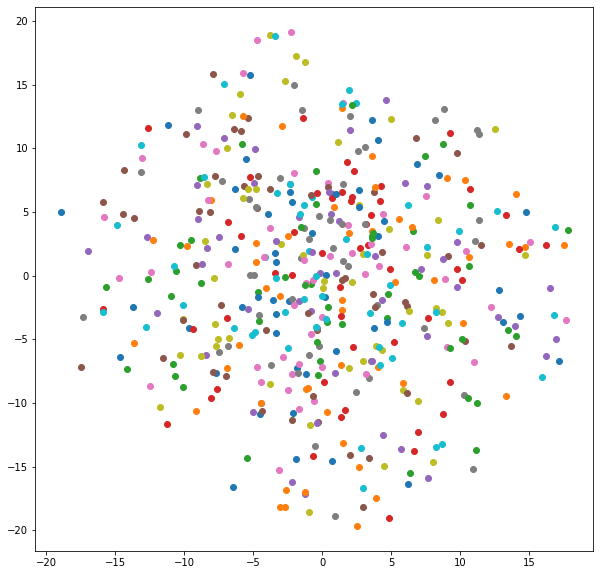

10.09382362064998


<Figure size 432x288 with 0 Axes>

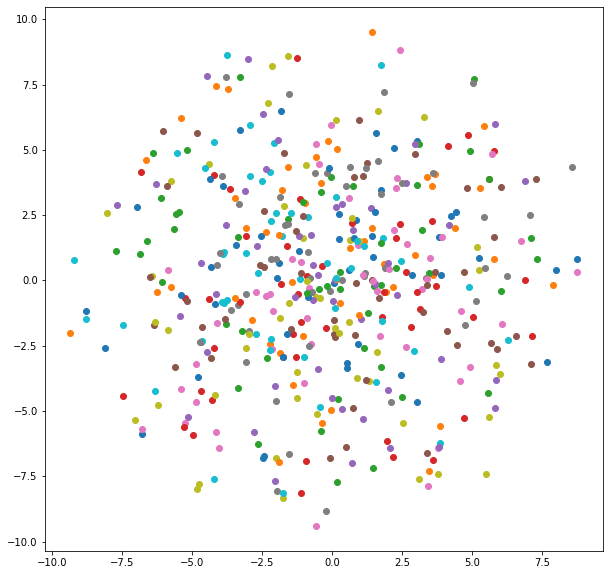

6.082569426862172


<Figure size 432x288 with 0 Axes>

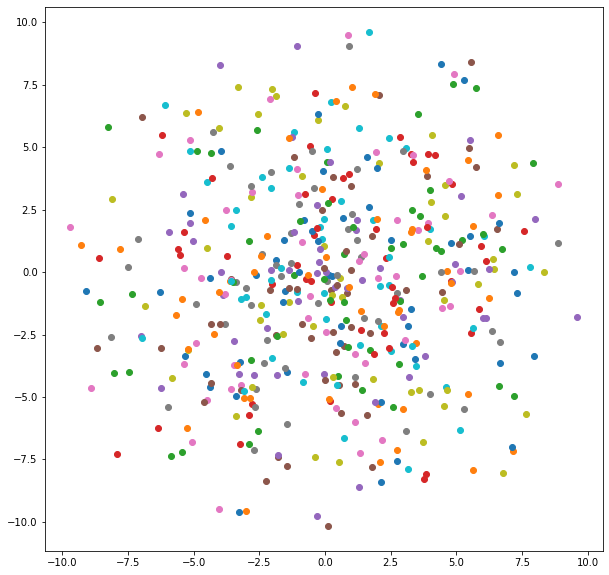

4.201070522655727


<Figure size 432x288 with 0 Axes>

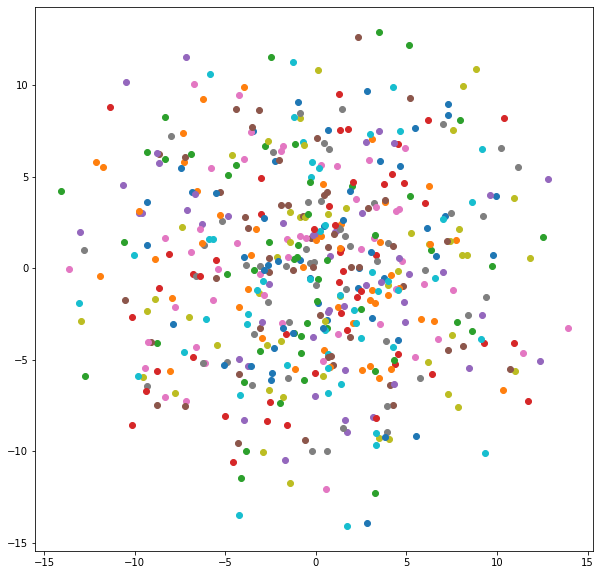

3.1725095403946844


<Figure size 432x288 with 0 Axes>

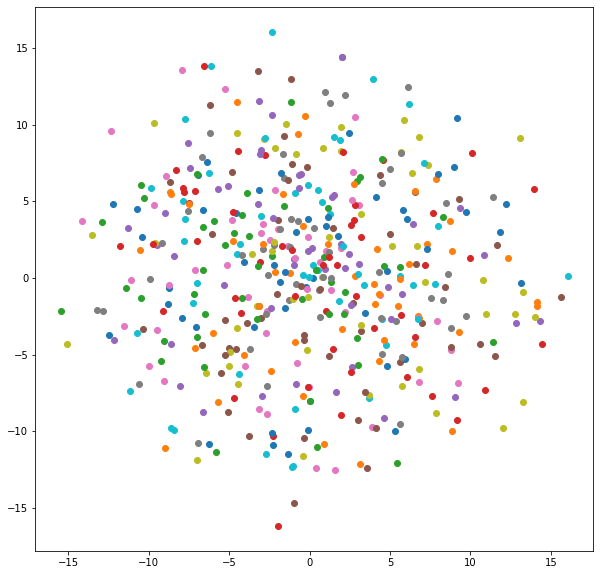

<Figure size 432x288 with 0 Axes>

In [28]:
model, losses = train_model()

In [22]:
ls

0.jpg  1.jpg  2.jpg  3.jpg  4.jpg  sample_data/
